In [1]:
import torch
import torchvision
from torchvision.models import resnet50

In [2]:
# add parent dir for loading helpers
import sys
sys.path.insert(1, '../')

In [3]:
rgb_weights = torch.load("../models/rgb_3c_model_89.pth", map_location='cpu', weights_only=False)
rgb_model = torchvision.models.get_model("resnet50", weights=None, num_classes=1000)
rgb_model.load_state_dict(rgb_weights["model"])
# rgb_model = torch.nn.Sequential(*list(rgb_model.children())[:9])

<All keys matched successfully>

In [8]:
rgb_model = torchvision.models.get_model("resnet50", weights=None, num_classes=1000)
rgb_model.load_state_dict(rgb_weights["model"])

rgb_model = torch.nn.Sequential(*list(rgb_model.children())[:9])

In [5]:
# model2_backbone = torch.nn.Sequential(*list(full_model.children())[:9])
# model2_classifier = RadImageNetClassifier(num_class=num_class)
# model2_comparable = nn.Sequential(model2_backbone, model2_classifier)

from helpers import radimagenet
from torch import nn

backbone = radimagenet.RadImageNetBackbone()
classifier = radimagenet.RadImageNetClassifier(num_class=1)

backbone.load_state_dict(torch.load("../models/radimagenet_resnet50.pt"))
model2_backbone = torch.nn.Sequential(*list(backbone.children())[:9])
# model2_classifier = RadImageNetClassifier(num_class=num_class)
model2_comparable = nn.Sequential(model2_backbone, classifier)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Load Data

### Create Custom Dataset

In [6]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from tqdm import tqdm
import torch

class ImagePairDataset(Dataset):
    """Custom dataset for loading image pairs organized as:
    root/class_name/pair_name/lung_l.png
    root/class_name/pair_name/lung_r.png
    """
    
    def __init__(self, root, transform=None, image_names=('lung_l.png', 'lung_r.png')):
        """
        Args:
            root (str): Root directory path
            transform: torchvision transforms to apply to both images
            image_names (tuple): Names of the two images in each pair folder
        """
        self.root = root
        self.transform = transform
        self.image_names = image_names
        
        # Build the dataset index
        self.pairs = []
        self.class_to_idx = {}
        self._build_dataset()
        
    def _build_dataset(self):
        """Build list of all image pairs and create class mappings"""
        classes = sorted([d for d in os.listdir(self.root) 
                         if os.path.isdir(os.path.join(self.root, d))])
        
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        
        for class_name in tqdm(classes, desc="Loading dataset"):
            class_path = os.path.join(self.root, class_name)
            class_idx = self.class_to_idx[class_name]
            
            # Get all pair directories in this class
            pair_dirs = [d for d in os.listdir(class_path) 
                        if os.path.isdir(os.path.join(class_path, d))]
            
            for pair_name in pair_dirs:
                pair_path = os.path.join(class_path, pair_name)
                
                # Check if both images exist
                lungl_path = os.path.join(pair_path, self.image_names[0])
                lungr_path = os.path.join(pair_path, self.image_names[1])
                # print(f"lungl_path: {lungl_path}")
                # print(f"lungr_path: {lungr_path}")
                if os.path.exists(lungl_path) and os.path.exists(lungr_path):
                    self.pairs.append({
                        'class_name': class_name,
                        'class_idx': class_idx,
                        'pair_name': pair_name,
                        'lungl_path': lungl_path,
                        'lungr_path': lungr_path
                    })
                else:
                    print(f"Warning: Missing images in {pair_path}")
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        """
        Returns:
            tuple: (lungl, lungr, class_idx, lungl_path, lungr_path)
        """
        pair_info = self.pairs[idx]

        print(f"PAIR INFO: {pair_info}")
        # Load images
        lungl = Image.open(pair_info['lungl_path']).convert('RGB')
        lungr = Image.open(pair_info['lungl_path']).convert('RGB')
        
        # Apply transforms
        if self.transform:
            lungl = self.transform(lungl)
            lungr = self.transform(lungr)
        
        return (
            lungl, 
            lungr, 
            pair_info['class_idx'],
            pair_info['lungl_path'],
            pair_info['lungr_path']
        )
    
    def get_class_name(self, class_idx):
        """Get class name from class index"""
        idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        return idx_to_class[class_idx]
    
    def get_pairs_by_class(self, class_name):
        """Get all pairs for a specific class"""
        return [pair for pair in self.pairs if pair['class_name'] == class_name]
    
    def print_dataset_info(self):
        """Print dataset statistics"""
        print(f"Total pairs: {len(self.pairs)}")
        print(f"Number of classes: {len(self.class_to_idx)}")
        
        # Count pairs per class
        class_counts = {}
        for pair in self.pairs:
            class_name = pair['class_name']
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        print("\nPairs per class:")
        for class_name, count in sorted(class_counts.items()):
            print(f"  {class_name}: {count}")


def load_image_pair_dataset(dataset_path, crop_size=512, batch_size=4, 
                           shuffle=True, transform=None, image_names=('lung_l.png', 'lung_r.png')):
    """
    Wrapper function to load image pair dataset with DataLoader
    
    Args:
        dataset_path (str): Path to dataset root
        crop_size (int): Size for image cropping/resizing
        batch_size (int): Batch size for DataLoader
        shuffle (bool): Whether to shuffle the dataset
        transform: Custom transform, if None will use default ResNet50 transforms
        image_names (tuple): Names of the two images in each pair folder
    
    Returns:
        DataLoader: Configured DataLoader for the dataset
    """
    
    # Default ResNet50 transforms if none provided
    if transform is None:
        from torchvision import transforms
        transform = transforms.Compose([
            transforms.Resize((crop_size, crop_size)),
            transforms.ToTensor(),
            # transforms.Normalize(
            #     mean=[0.485, 0.456, 0.406],  # ImageNet means
            #     std=[0.229, 0.224, 0.225]    # ImageNet stds
            # )
        ])
    
    dataset = ImagePairDataset(
        root=dataset_path,
        transform=transform,
        image_names=image_names
    )
    
    # Print dataset info
    dataset.print_dataset_info()
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# Example usage:
# if __name__ == "__main__":
# Test the dataset
dataset_path = "../split_node21"

# Load with default settings
dataloader = load_image_pair_dataset(
    dataset_path=dataset_path,
    batch_size=8,
    crop_size=224  # Standard ResNet50 input size
)

# Test loading a batch
for batch_idx, (lungl, lungr, class_idx, path1, path2) in enumerate(dataloader):
    print(f"Batch {batch_idx}:")
    print(f"  lungl shape: {lungl.shape}")
    print(f"  lungr shape: {lungr.shape}")
    print(f"  Class indices: {class_idx}")
    print(f"  Sample paths: {path1[0]}, {path2[0]}")
    if batch_idx == 0:  # Just show first batch
        break

Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Total pairs: 3688
Number of classes: 2

Pairs per class:
  nodule: 1060
  normal: 2628
PAIR INFO: {'class_name': 'normal', 'class_idx': 1, 'pair_name': 'c2745', 'lungl_path': '../split_node21/normal/c2745/lung_l.png', 'lungr_path': '../split_node21/normal/c2745/lung_r.png'}
PAIR INFO: {'class_name': 'normal', 'class_idx': 1, 'pair_name': 'c2898', 'lungl_path': '../split_node21/normal/c2898/lung_l.png', 'lungr_path': '../split_node21/normal/c2898/lung_r.png'}
PAIR INFO: {'class_name': 'normal', 'class_idx': 1, 'pair_name': 'c2681', 'lungl_path': '../split_node21/normal/c2681/lung_l.png', 'lungr_path': '../split_node21/normal/c2681/lung_r.png'}
PAIR INFO: {'class_name': 'normal', 'class_idx': 1, 'pair_name': 'c3680', 'lungl_path': '../split_node21/normal/c3680/lung_l.png', 'lungr_path': '../split_node21/normal/c3680/lung_r.png'}
PAIR INFO: {'class_name': 'normal', 'class_idx': 1, 'pair_name': 'c1847', 'lungl_path': '../split_node21/normal/c1847/lung_l.png', 'lungr_path': '../split_node21

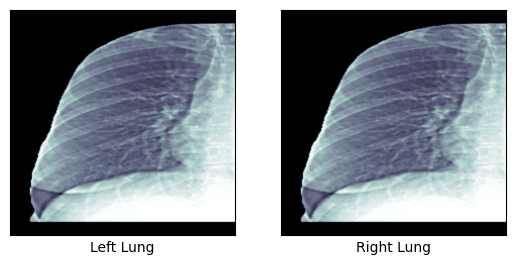

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.setp(ax.get_xticklabels(),visible=(False))
plt.setp(ax.get_yticklabels(),visible=(False))
ax.imshow(lungl[0][0],cmap="bone")
ax.set_xlabel('Left Lung')
ax.tick_params(axis='both', which='both', length=0)

ax2 = fig.add_subplot(1,2,2)
plt.setp(ax2.get_xticklabels(),visible=(False))
plt.setp(ax2.get_yticklabels(),visible=(False))
# ax2.imshow(np.flip(lung_r, axis=1),cmap="bone")
ax2.imshow(lungl[0][0],cmap="bone")

ax2.set_xlabel('Right Lung')
ax2.tick_params(axis='both', which='both', length=0)

## Contrastive

In [ ]:
class TrainableSimilarityNetwork(nn.Module):
    """
    Trainable similarity network with different loss functions
    """
    
    def __init__(self, pretrained=True, freeze_backbone=False, embedding_dim=128):
        """
        Args:
            pretrained (bool): Use pre-trained ResNet50 weights
            freeze_backbone (bool): Freeze ResNet50 parameters
            embedding_dim (int): Dimension of final embedding layer
        """
        super(TrainableSimilarityNetwork, self).__init__()
        
        # Load ResNet50 backbone
        backbone = models.resnet50(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        
        # Freeze backbone if specified
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Add projection head for contrastive learning
        self.projection_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
        )
        
        self.embedding_dim = embedding_dim
    
    def forward(self, x):
        """Extract embeddings from input images"""
        features = self.backbone(x)
        features = features.view(features.size(0), -1)
        embeddings = self.projection_head(features)
        return embeddings
    
    def forward_pair(self, img1, img2):
        """Forward pass for image pairs"""
        emb1 = self.forward(img1)
        emb2 = self.forward(img2)
        return emb1, emb2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import numpy as np



# Loss Functions for Pair Training
class ContrastiveLoss(nn.Module):
    """
    Contrastive Loss for pair training
    Pulls similar pairs together, pushes dissimilar pairs apart
    """
    
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, emb1, emb2, labels):
        """
        Args:
            emb1, emb2: Embeddings [batch_size, embedding_dim]
            labels: 1 for similar pairs, 0 for dissimilar pairs
        """
        # Euclidean distance
        distances = F.pairwise_distance(emb1, emb2)
        
        # Contrastive loss
        loss_similar = labels * torch.pow(distances, 2)
        loss_dissimilar = (1 - labels) * torch.pow(torch.clamp(self.margin - distances, min=0.0), 2)
        
        loss = torch.mean(loss_similar + loss_dissimilar)
        return loss


class TripletLoss(nn.Module):
    """
    Triplet Loss: anchor, positive, negative
    """
    
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        """
        Args:
            anchor, positive, negative: Embeddings [batch_size, embedding_dim]
        """
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        
        loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0)
        return torch.mean(loss)


class CosineSimilarityLoss(nn.Module):
    """
    Cosine similarity-based loss
    """
    
    def __init__(self, temperature=0.5):
        super(CosineSimilarityLoss, self).__init__()
        self.temperature = temperature
    
    def forward(self, emb1, emb2, labels):
        """
        Args:
            emb1, emb2: Embeddings [batch_size, embedding_dim]
            labels: 1 for similar pairs, 0 for dissimilar pairs
        """
        # Normalize embeddings
        emb1_norm = F.normalize(emb1, p=2, dim=1)
        emb2_norm = F.normalize(emb2, p=2, dim=1)
        
        # Cosine similarity
        cos_sim = F.cosine_similarity(emb1_norm, emb2_norm, dim=1)
        
        # Scale by temperature
        cos_sim = cos_sim / self.temperature
        
        # Convert to probabilities
        probs = torch.sigmoid(cos_sim)
        
        # Binary cross entropy
        loss = F.binary_cross_entropy(probs, labels.float())
        return loss


# Training Pipeline
class SimilarityTrainer:
    """
    Trainer class for similarity networks
    """
    
    def __init__(self, model, loss_fn, optimizer, device='cuda'):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device
        self.train_losses = []
        self.val_losses = []
    
    def train_epoch(self, train_loader, epoch):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        num_batches = 0
        
        for batch_idx, (img1, img2, labels, _, _) in enumerate(train_loader):
            img1, img2, labels = img1.to(self.device), img2.to(self.device), labels.to(self.device)
            
            # Forward pass
            emb1, emb2 = self.model.forward_pair(img1, img2)
            
            # Compute loss
            loss = self.loss_fn(emb1, emb2, labels)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')
        
        avg_loss = total_loss / num_batches
        self.train_losses.append(avg_loss)
        return avg_loss
    
    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        num_batches = 0
        
        with torch.no_grad():
            for img1, img2, labels, _, _ in val_loader:
                img1, img2, labels = img1.to(self.device), img2.to(self.device), labels.to(self.device)
                
                emb1, emb2 = self.model.forward_pair(img1, img2)
                loss = self.loss_fn(emb1, emb2, labels)
                
                total_loss += loss.item()
                num_batches += 1
        
        avg_loss = total_loss / num_batches
        self.val_losses.append(avg_loss)
        return avg_loss
    
    def train(self, train_loader, val_loader, num_epochs, save_path=None):
        """Full training loop"""
        best_val_loss = float('inf')
        
        for epoch in range(num_epochs):
            # Train
            train_loss = self.train_epoch(train_loader, epoch)
            
            # Validate
            val_loss = self.validate(val_loader)
            
            print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            
            # Save best model
            if val_loss < best_val_loss and save_path:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), save_path)
                print(f'Saved best model with val loss: {val_loss:.4f}')


# Data Preparation for Training
def prepare_training_data(pairs_dataset, train_split=0.8):
    """
    Prepare training data with positive and negative pairs
    
    Your current dataset only has positive pairs (same class).
    For training, you need negative pairs (different classes).
    """
    
    # Get all pairs by class
    pairs_by_class = {}
    for i in range(len(pairs_dataset)):
        _, _, class_idx, _, _ = pairs_dataset[i]
        if class_idx not in pairs_by_class:
            pairs_by_class[class_idx] = []
        pairs_by_class[class_idx].append(i)
    
    # Create positive and negative pairs
    positive_pairs = []
    negative_pairs = []
    
    classes = list(pairs_by_class.keys())
    
    # Positive pairs: existing same-class pairs
    for class_idx, pair_indices in pairs_by_class.items():
        for pair_idx in pair_indices:
            positive_pairs.append((pair_idx, 1))  # (index, label)
    
    # Negative pairs: cross-class pairs
    # Sample equal number of negative pairs
    num_negative = len(positive_pairs)
    for _ in range(num_negative):
        # Pick two different classes
        class1, class2 = np.random.choice(classes, 2, replace=False)
        
        # Pick random pairs from each class
        pair1_idx = np.random.choice(pairs_by_class[class1])
        pair2_idx = np.random.choice(pairs_by_class[class2])
        
        negative_pairs.append((pair1_idx, pair2_idx, 0))  # (idx1, idx2, label)
    
    return positive_pairs, negative_pairs


# Custom Dataset for Training
class TrainingPairDataset(torch.utils.data.Dataset):
    """
    Dataset that combines positive and negative pairs for training
    """
    
    def __init__(self, base_dataset, positive_pairs, negative_pairs):
        self.base_dataset = base_dataset
        self.positive_pairs = positive_pairs
        self.negative_pairs = negative_pairs
        
        # Combine all pairs
        self.all_pairs = []
        
        # Add positive pairs
        for pair_idx, label in positive_pairs:
            self.all_pairs.append(('positive', pair_idx, label))
        
        # Add negative pairs
        for pair_idx1, pair_idx2, label in negative_pairs:
            self.all_pairs.append(('negative', pair_idx1, pair_idx2, label))
    
    def __len__(self):
        return len(self.all_pairs)
    
    def __getitem__(self, idx):
        pair_info = self.all_pairs[idx]
        
        if pair_info[0] == 'positive':
            # Same class pair
            _, pair_idx, label = pair_info
            img1, img2, class_idx, _, _ = self.base_dataset[pair_idx]
            return img1, img2, label
        
        else:
            # Cross class pair
            _, pair_idx1, pair_idx2, label = pair_info
            img1, _, _, _, _ = self.base_dataset[pair_idx1]
            img2, _, _, _, _ = self.base_dataset[pair_idx2]
            return img1, img2, label


# Example Usage
def train_similarity_network(pairs_dataset, num_epochs=50, lr=0.001):
    """
    Complete training pipeline
    """
    
    # Prepare training data
    positive_pairs, negative_pairs = prepare_training_data(pairs_dataset)
    
    # Create training dataset
    train_dataset = TrainingPairDataset(pairs_dataset, positive_pairs, negative_pairs)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Create model
    model = TrainableSimilarityNetwork(pretrained=True, freeze_backbone=False, embedding_dim=128)
    
    # Choose loss function
    loss_fn = ContrastiveLoss(margin=1.0)
    # loss_fn = CosineSimilarityLoss(temperature=0.5)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Trainer
    trainer = SimilarityTrainer(model, loss_fn, optimizer)
    
    # Train
    trainer.train(train_loader, train_loader, num_epochs, save_path='best_similarity_model.pth')
    
    return model, trainer

# Example usage:
# model, trainer = train_similarity_network(your_pairs_dataset, num_epochs=20)

## Pass through images

In [123]:
# Freeze the Models
for param in rgb_model.parameters():
    param.requires_grad = False

for param in model2_comparable.parameters():
    param.requires_grad = False

In [125]:
from sklearn.feature_selection import mutual_info_regression

def mutual_information_sklearn(vec1, vec2):
    """
    Compute MI using sklearn's mutual_info_regression
    Treats one vector as features, other as target
    """
    # Reshape for sklearn
    X = vec1.reshape(-1, 1)
    y = vec2
    
    # Use sklearn's MI estimator
    mi_score = mutual_info_regression(X, y, random_state=42)[0]
    return mi_score

In [130]:
rgb_lungl.squeeze().reshape(-1, 1)

tensor([[0.4031],
        [0.3799],
        [0.5229],
        ...,
        [0.4278],
        [0.3895],
        [0.4207]])

In [131]:
rgb_lungl.squeeze()

tensor([0.4031, 0.3799, 0.5229,  ..., 0.4278, 0.3895, 0.4207])

In [134]:
mutual_info_regression(rgb_lungl.squeeze().reshape(-1, 1),rgb_lungr.squeeze())

array([6.36789095])

In [138]:
mutual_info_regression(rgb_lungl.squeeze().reshape(-1, 1),rgb_lungl.squeeze())

array([6.36789095])

In [124]:
for i in range(0, len(class_idx)):
    print(f"i: {i}")
    rgb_lungl = rgb_model(lungl[i:i+1])
    rgb_lungr = rgb_model(lungr[i:i+1])
    rad_lungl = model2_backbone(lungl[i:i+1])
    rad_lungr = model2_backbone(lungr[i:i+1])
    
    rgb_cosine_sim = F.cosine_similarity(rgb_lungl, rgb_lungr, dim=1)
    rgb_euclidean_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=2)
    rgb_manhattan_dist = F.pairwise_distance(rgb_lungl, rgb_lungr, p=1)

    rad_cosine_sim = F.cosine_similarity(rad_lungl, rad_lungr, dim=1)
    rad_euclidean_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=2)
    rad_manhattan_dist = F.pairwise_distance(rad_lungl, rad_lungr, p=1)

    rgb_mutual_info = mutual_information_sklearn(rgb_lungl.squeeze(), rgb_lungr.squeeze())
    rad_mutual_info = mutual_information_sklearn(rad_lungl.squeeze(), rad_lungr.squeeze())
    
    print("Class: Normal" if class_idx[i].item()==0 else "Class: Nodule")
    print("              RGB                 Rad")
    print(f"Cosine:      {rgb_cosine_sim.item()}   {rad_cosine_sim.item()}")
    print(f"Euclid min:  {rgb_euclidean_dist.squeeze().min().item()}   {rad_euclidean_dist.squeeze().min().item()}")
    print(f"Euclid max:  {rgb_euclidean_dist.squeeze().max().item()}   {rad_euclidean_dist.squeeze().max().item()}")
    print(f"Manhat min:  {rgb_manhattan_dist.squeeze().min().item()}   {rad_manhattan_dist.squeeze().min().item()}")
    print(f"Manhat max:  {rgb_manhattan_dist.squeeze().max().item()}   {rad_manhattan_dist.squeeze().max().item()}")
    print(f"Mutual info: {rgb_mutual_info}     {rad_mutual_info}")
    print("===================================================")

i: 0
Class: Normal
              RGB                 Rad
Cosine:      0.9999998211860657   1.0000001192092896
Euclid min:  9.999999974752427e-07   9.999999974752427e-07
Euclid max:  9.999999974752427e-07   9.999999974752427e-07
Manhat min:  9.999999974752427e-07   9.999999974752427e-07
Manhat max:  9.999999974752427e-07   9.999999974752427e-07
Mutual info: 6.368257157234384     6.368257157234384
i: 1
Class: Nodule
              RGB                 Rad
Cosine:      0.9999999403953552   1.0000001192092896
Euclid min:  9.999999974752427e-07   9.999999974752427e-07
Euclid max:  9.999999974752427e-07   9.999999974752427e-07
Manhat min:  9.999999974752427e-07   9.999999974752427e-07
Manhat max:  9.999999974752427e-07   9.999999974752427e-07
Mutual info: 6.368257157234384     6.368257157234384
i: 2
Class: Nodule
              RGB                 Rad
Cosine:      1.0   1.0
Euclid min:  9.999999974752427e-07   9.999999974752427e-07
Euclid max:  9.999999974752427e-07   9.999999974752427e-07
Manh